In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

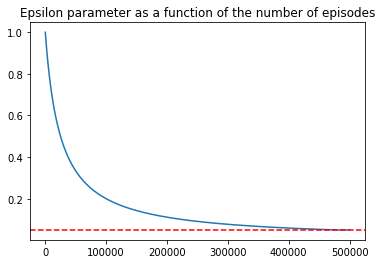

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 224
add_noise = True

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.08  minuts. epsilon 0.9961 Discounted reward:  -18.782931184680876
Episode: 200. Elapsed time  0.19  minuts. epsilon 0.9921 Discounted reward:  -19.38162491551783
Episode: 300. Elapsed time  0.32  minuts. epsilon 0.9882 Discounted reward:  -18.469989439573293
Episode: 400. Elapsed time  0.47  minuts. epsilon 0.9843 Discounted reward:  -14.173902277282762
Episode: 500. Elapsed time  0.63  minuts. epsilon 0.9804 Discounted reward:  -20.99001194789031
Episode: 600. Elapsed time  0.8  minuts. epsilon 0.9766 Discounted reward:  -19.966442827259062
Episode: 700. Elapsed time  0.98  minuts. epsilon 0.9728 Discounted reward:  -22.660757089217604
Episode: 800. Elapsed time  1.17  minuts. epsilon 0.969 Discounted reward:  -14.099787164509152
Episode: 900. Elapsed time  1.38  minuts. epsilon 0.9653 Discounted reward:  -15.413364187126831
Episode: 1000. Elapsed time  1.61  minuts. epsilon 0.9616 Discounted reward:  -21.633364625724134
Episode: 1100. Elapsed time  1.84

Episode: 8500. Elapsed time  34.45  minuts. epsilon 0.7463 Discounted reward:  -13.26989451562083
Episode: 8600. Elapsed time  35.03  minuts. epsilon 0.7441 Discounted reward:  -10.574161311628112
Episode: 8700. Elapsed time  35.61  minuts. epsilon 0.7419 Discounted reward:  -12.121062392475654
Episode: 8800. Elapsed time  36.18  minuts. epsilon 0.7397 Discounted reward:  -16.08666598487829
Episode: 8900. Elapsed time  36.76  minuts. epsilon 0.7375 Discounted reward:  -11.893327944895299
Episode: 9000. Elapsed time  37.35  minuts. epsilon 0.7353 Discounted reward:  -15.302692205441913
Episode: 9100. Elapsed time  37.92  minuts. epsilon 0.7332 Discounted reward:  -11.829465629728531
Episode: 9200. Elapsed time  38.51  minuts. epsilon 0.731 Discounted reward:  -17.070784107348253
Episode: 9300. Elapsed time  39.11  minuts. epsilon 0.7289 Discounted reward:  -8.884455218004527
Episode: 9400. Elapsed time  39.73  minuts. epsilon 0.7268 Discounted reward:  -7.14013718601644
Episode: 9500. E

Episode: 16800. Elapsed time  89.87  minuts. epsilon 0.5981 Discounted reward:  -7.366597477349043
Episode: 16900. Elapsed time  90.61  minuts. epsilon 0.5967 Discounted reward:  -10.206658132167046
Episode: 17000. Elapsed time  91.33  minuts. epsilon 0.5953 Discounted reward:  -12.58445687199159
Episode: 17100. Elapsed time  92.07  minuts. epsilon 0.5938 Discounted reward:  -15.457554667589921
Episode: 17200. Elapsed time  92.79  minuts. epsilon 0.5924 Discounted reward:  -13.048346670009591
Episode: 17300. Elapsed time  93.53  minuts. epsilon 0.591 Discounted reward:  -11.862729223219768
Episode: 17400. Elapsed time  94.26  minuts. epsilon 0.5896 Discounted reward:  -10.142971397475923
Episode: 17500. Elapsed time  95.0  minuts. epsilon 0.5882 Discounted reward:  -9.784265695853337
Episode: 17600. Elapsed time  95.74  minuts. epsilon 0.5869 Discounted reward:  -4.011374423946139
Episode: 17700. Elapsed time  96.47  minuts. epsilon 0.5855 Discounted reward:  -7.9194372751344835
Episod

Episode: 25000. Elapsed time  153.22  minuts. epsilon 0.5 Discounted reward:  -10.803305356684918
Episode: 25100. Elapsed time  153.99  minuts. epsilon 0.499 Discounted reward:  -14.943361584547675
Episode: 25200. Elapsed time  154.77  minuts. epsilon 0.498 Discounted reward:  -6.4552558771110755
Episode: 25300. Elapsed time  155.56  minuts. epsilon 0.497 Discounted reward:  -7.075908151335517
Episode: 25400. Elapsed time  156.36  minuts. epsilon 0.496 Discounted reward:  -4.621520929920025
Episode: 25500. Elapsed time  157.17  minuts. epsilon 0.4951 Discounted reward:  -7.037555168881668
Episode: 25600. Elapsed time  157.97  minuts. epsilon 0.4941 Discounted reward:  -14.311875719035273
Episode: 25700. Elapsed time  158.78  minuts. epsilon 0.4931 Discounted reward:  -2.6469208668726383
Episode: 25800. Elapsed time  159.58  minuts. epsilon 0.4921 Discounted reward:  -5.409562140632532
Episode: 25900. Elapsed time  160.43  minuts. epsilon 0.4912 Discounted reward:  -8.639646167698782
Ep

Episode: 33200. Elapsed time  222.31  minuts. epsilon 0.4296 Discounted reward:  -4.63059099766994
Episode: 33300. Elapsed time  223.17  minuts. epsilon 0.4288 Discounted reward:  -4.351025474257897
Episode: 33400. Elapsed time  224.04  minuts. epsilon 0.4281 Discounted reward:  -3.695491874782902
Episode: 33500. Elapsed time  224.92  minuts. epsilon 0.4274 Discounted reward:  -7.080272963996555
Episode: 33600. Elapsed time  225.81  minuts. epsilon 0.4266 Discounted reward:  -7.808729187285165
Episode: 33700. Elapsed time  226.68  minuts. epsilon 0.4259 Discounted reward:  -6.5567405480017955
Episode: 33800. Elapsed time  227.55  minuts. epsilon 0.4252 Discounted reward:  -4.808796028974208
Episode: 33900. Elapsed time  228.43  minuts. epsilon 0.4245 Discounted reward:  -7.895290231990415
Episode: 34000. Elapsed time  229.31  minuts. epsilon 0.4237 Discounted reward:  -4.45101188004646
Episode: 34100. Elapsed time  230.2  minuts. epsilon 0.423 Discounted reward:  -4.806284484158636
Epi

Episode: 41400. Elapsed time  295.29  minuts. epsilon 0.3765 Discounted reward:  -5.755312237623447
Episode: 41500. Elapsed time  296.19  minuts. epsilon 0.3759 Discounted reward:  -2.61339225954318
Episode: 41600. Elapsed time  297.1  minuts. epsilon 0.3754 Discounted reward:  -4.809414304140724
Episode: 41700. Elapsed time  298.01  minuts. epsilon 0.3748 Discounted reward:  -3.900315181538689
Episode: 41800. Elapsed time  298.92  minuts. epsilon 0.3743 Discounted reward:  -4.177316931614022
Episode: 41900. Elapsed time  299.84  minuts. epsilon 0.3737 Discounted reward:  -2.495331611811771
Episode: 42000. Elapsed time  300.75  minuts. epsilon 0.3731 Discounted reward:  -2.827618393282694
Episode: 42100. Elapsed time  301.67  minuts. epsilon 0.3726 Discounted reward:  -4.443386741567688
Episode: 42200. Elapsed time  302.58  minuts. epsilon 0.372 Discounted reward:  -7.094403840143975
Episode: 42300. Elapsed time  303.48  minuts. epsilon 0.3715 Discounted reward:  -6.475187406872632
Epi

Episode: 49600. Elapsed time  371.12  minuts. epsilon 0.3351 Discounted reward:  -1.1818609388782244
Episode: 49700. Elapsed time  372.09  minuts. epsilon 0.3347 Discounted reward:  -7.7877207306316825
Episode: 49800. Elapsed time  373.04  minuts. epsilon 0.3342 Discounted reward:  -5.045744035704161
Episode: 49900. Elapsed time  373.98  minuts. epsilon 0.3338 Discounted reward:  -5.020655950854451
Episode: 50000. Elapsed time  374.92  minuts. epsilon 0.3333 Discounted reward:  -7.2098983194130195
Episode: 50100. Elapsed time  375.87  minuts. epsilon 0.3329 Discounted reward:  -4.108133029291729
Episode: 50200. Elapsed time  376.79  minuts. epsilon 0.3325 Discounted reward:  -4.261836461862278
Episode: 50300. Elapsed time  377.74  minuts. epsilon 0.332 Discounted reward:  -9.30103446711224
Episode: 50400. Elapsed time  378.68  minuts. epsilon 0.3316 Discounted reward:  -8.103460261875055
Episode: 50500. Elapsed time  379.63  minuts. epsilon 0.3311 Discounted reward:  -3.591026164862874

Episode: 57800. Elapsed time  450.86  minuts. epsilon 0.3019 Discounted reward:  -2.7400058713599296
Episode: 57900. Elapsed time  451.82  minuts. epsilon 0.3016 Discounted reward:  -3.509314354692879
Episode: 58000. Elapsed time  452.81  minuts. epsilon 0.3012 Discounted reward:  -7.08873262703062
Episode: 58100. Elapsed time  453.79  minuts. epsilon 0.3008 Discounted reward:  -5.224071710680964
Episode: 58200. Elapsed time  454.76  minuts. epsilon 0.3005 Discounted reward:  -5.137823113045746
Episode: 58300. Elapsed time  455.72  minuts. epsilon 0.3001 Discounted reward:  -1.1796072874525527
Episode: 58400. Elapsed time  456.7  minuts. epsilon 0.2998 Discounted reward:  -3.0659607739022645
Episode: 58500. Elapsed time  457.68  minuts. epsilon 0.2994 Discounted reward:  -9.078108305282829
Episode: 58600. Elapsed time  458.64  minuts. epsilon 0.299 Discounted reward:  -2.5074592326059406
Episode: 58700. Elapsed time  459.62  minuts. epsilon 0.2987 Discounted reward:  -3.442153361228281

Episode: 66000. Elapsed time  531.31  minuts. epsilon 0.2747 Discounted reward:  -1.1466167526833695
Episode: 66100. Elapsed time  532.28  minuts. epsilon 0.2744 Discounted reward:  -5.011079720233689
Episode: 66200. Elapsed time  533.27  minuts. epsilon 0.2741 Discounted reward:  -3.148439222766491
Episode: 66300. Elapsed time  534.23  minuts. epsilon 0.2738 Discounted reward:  -2.147157300723184
Episode: 66400. Elapsed time  535.21  minuts. epsilon 0.2735 Discounted reward:  -3.5783941045746537
Episode: 66500. Elapsed time  536.19  minuts. epsilon 0.2732 Discounted reward:  -1.870927114424615
Episode: 66600. Elapsed time  537.16  minuts. epsilon 0.2729 Discounted reward:  -3.985336921465948
Episode: 66700. Elapsed time  538.12  minuts. epsilon 0.2726 Discounted reward:  -1.940868278604719
Episode: 66800. Elapsed time  539.11  minuts. epsilon 0.2723 Discounted reward:  -3.028566449544151
Episode: 66900. Elapsed time  540.1  minuts. epsilon 0.272 Discounted reward:  -2.8043619119387913

Episode: 74200. Elapsed time  612.38  minuts. epsilon 0.252 Discounted reward:  -4.338881715169484
Episode: 74300. Elapsed time  613.38  minuts. epsilon 0.2518 Discounted reward:  -5.4237047392245685
Episode: 74400. Elapsed time  614.35  minuts. epsilon 0.2515 Discounted reward:  -4.569348387953109
Episode: 74500. Elapsed time  615.32  minuts. epsilon 0.2513 Discounted reward:  -4.409227181908609
Episode: 74600. Elapsed time  616.31  minuts. epsilon 0.251 Discounted reward:  -2.6299079896076187
Episode: 74700. Elapsed time  617.28  minuts. epsilon 0.2508 Discounted reward:  -2.6765104068062753
Episode: 74800. Elapsed time  618.31  minuts. epsilon 0.2505 Discounted reward:  -3.1122727751202395
Episode: 74900. Elapsed time  619.28  minuts. epsilon 0.2503 Discounted reward:  -1.9202708747707042
Episode: 75000. Elapsed time  620.29  minuts. epsilon 0.25 Discounted reward:  -5.088756639732144
Episode: 75100. Elapsed time  621.31  minuts. epsilon 0.2498 Discounted reward:  -2.010013983984600

Episode: 82400. Elapsed time  694.69  minuts. epsilon 0.2328 Discounted reward:  -1.0253889417401385
Episode: 82500. Elapsed time  695.69  minuts. epsilon 0.2326 Discounted reward:  -2.448117375049559
Episode: 82600. Elapsed time  696.71  minuts. epsilon 0.2323 Discounted reward:  -2.0249959997132976
Episode: 82700. Elapsed time  697.73  minuts. epsilon 0.2321 Discounted reward:  -1.3863451365022308
Episode: 82800. Elapsed time  698.73  minuts. epsilon 0.2319 Discounted reward:  -3.427170458249161
Episode: 82900. Elapsed time  699.74  minuts. epsilon 0.2317 Discounted reward:  -2.099743969485184
Episode: 83000. Elapsed time  700.76  minuts. epsilon 0.2315 Discounted reward:  -1.0133053900484106
Episode: 83100. Elapsed time  701.78  minuts. epsilon 0.2313 Discounted reward:  -5.526711957080024
Episode: 83200. Elapsed time  702.78  minuts. epsilon 0.2311 Discounted reward:  -6.332487942716251
Episode: 83300. Elapsed time  703.79  minuts. epsilon 0.2308 Discounted reward:  -4.279130141292

Episode: 90600. Elapsed time  778.05  minuts. epsilon 0.2163 Discounted reward:  -6.836824260273583
Episode: 90700. Elapsed time  779.07  minuts. epsilon 0.2161 Discounted reward:  -3.1982213146773577
Episode: 90800. Elapsed time  780.11  minuts. epsilon 0.2159 Discounted reward:  -1.914152054236346
Episode: 90900. Elapsed time  781.16  minuts. epsilon 0.2157 Discounted reward:  -0.9107340217892435
Episode: 91000. Elapsed time  782.19  minuts. epsilon 0.2155 Discounted reward:  -1.5534781654035803
Episode: 91100. Elapsed time  783.23  minuts. epsilon 0.2153 Discounted reward:  -3.1620040243957805
Episode: 91200. Elapsed time  784.23  minuts. epsilon 0.2151 Discounted reward:  -1.5991352843930062
Episode: 91300. Elapsed time  785.27  minuts. epsilon 0.215 Discounted reward:  -4.420344817411583
Episode: 91400. Elapsed time  786.31  minuts. epsilon 0.2148 Discounted reward:  -0.5840460983014631
Episode: 91500. Elapsed time  787.33  minuts. epsilon 0.2146 Discounted reward:  -1.12988710963

Episode: 98800. Elapsed time  862.69  minuts. epsilon 0.2019 Discounted reward:  -3.415424050945473
Episode: 98900. Elapsed time  863.73  minuts. epsilon 0.2018 Discounted reward:  -1.1818533927371715
Episode: 99000. Elapsed time  864.79  minuts. epsilon 0.2016 Discounted reward:  -2.020889966478088
Episode: 99100. Elapsed time  865.85  minuts. epsilon 0.2015 Discounted reward:  -1.455619928951166
Episode: 99200. Elapsed time  866.89  minuts. epsilon 0.2013 Discounted reward:  -4.556198752988901
Episode: 99300. Elapsed time  867.93  minuts. epsilon 0.2011 Discounted reward:  -3.917463072709261
Episode: 99400. Elapsed time  868.98  minuts. epsilon 0.201 Discounted reward:  -1.258029826878046
Episode: 99500. Elapsed time  870.0  minuts. epsilon 0.2008 Discounted reward:  -2.9398250731177304
Episode: 99600. Elapsed time  871.03  minuts. epsilon 0.2006 Discounted reward:  -2.981180457102376
Episode: 99700. Elapsed time  872.07  minuts. epsilon 0.2005 Discounted reward:  -1.4970236578702607

Episode: 106900. Elapsed time  946.84  minuts. epsilon 0.1895 Discounted reward:  -5.06970330839929
Episode: 107000. Elapsed time  947.92  minuts. epsilon 0.1894 Discounted reward:  -2.306800785919377
Episode: 107100. Elapsed time  948.97  minuts. epsilon 0.1893 Discounted reward:  -4.6874300617434885
Episode: 107200. Elapsed time  950.05  minuts. epsilon 0.1891 Discounted reward:  -0.916345258601394
Episode: 107300. Elapsed time  951.09  minuts. epsilon 0.189 Discounted reward:  -0.5818871864160728
Episode: 107400. Elapsed time  952.15  minuts. epsilon 0.1888 Discounted reward:  -0.31953497388314867
Episode: 107500. Elapsed time  953.17  minuts. epsilon 0.1887 Discounted reward:  -0.39913631954928774
Episode: 107600. Elapsed time  954.22  minuts. epsilon 0.1885 Discounted reward:  -0.19770670273875493
Episode: 107700. Elapsed time  955.26  minuts. epsilon 0.1884 Discounted reward:  -0.8750757565755107
Episode: 107800. Elapsed time  956.32  minuts. epsilon 0.1883 Discounted reward:  -1

Episode: 115000. Elapsed time  1031.79  minuts. epsilon 0.1786 Discounted reward:  -0.4442479931846488
Episode: 115100. Elapsed time  1032.85  minuts. epsilon 0.1784 Discounted reward:  -1.4782137258717885
Episode: 115200. Elapsed time  1033.92  minuts. epsilon 0.1783 Discounted reward:  -1.7701156166464331
Episode: 115300. Elapsed time  1035.0  minuts. epsilon 0.1782 Discounted reward:  -1.7710123634627335
Episode: 115400. Elapsed time  1036.08  minuts. epsilon 0.1781 Discounted reward:  -5.645211155632168
Episode: 115500. Elapsed time  1037.14  minuts. epsilon 0.1779 Discounted reward:  -0.9930928546949904
Episode: 115600. Elapsed time  1038.21  minuts. epsilon 0.1778 Discounted reward:  -1.0360689395784644
Episode: 115700. Elapsed time  1039.26  minuts. epsilon 0.1777 Discounted reward:  -1.811046218824933
Episode: 115800. Elapsed time  1040.32  minuts. epsilon 0.1776 Discounted reward:  -3.281558157578223
Episode: 115900. Elapsed time  1041.37  minuts. epsilon 0.1774 Discounted rew

Episode: 123000. Elapsed time  1116.51  minuts. epsilon 0.1689 Discounted reward:  -3.4658558258387733
Episode: 123100. Elapsed time  1117.56  minuts. epsilon 0.1688 Discounted reward:  -0.7045336960502154
Episode: 123200. Elapsed time  1118.62  minuts. epsilon 0.1687 Discounted reward:  -0.375299470068713
Episode: 123300. Elapsed time  1119.69  minuts. epsilon 0.1686 Discounted reward:  -0.8200230485349436
Episode: 123400. Elapsed time  1120.76  minuts. epsilon 0.1685 Discounted reward:  -0.9747443172331136
Episode: 123500. Elapsed time  1121.82  minuts. epsilon 0.1684 Discounted reward:  -3.279640917949182
Episode: 123600. Elapsed time  1122.88  minuts. epsilon 0.1682 Discounted reward:  -2.6926343075287735
Episode: 123700. Elapsed time  1123.94  minuts. epsilon 0.1681 Discounted reward:  -0.4068513153259447
Episode: 123800. Elapsed time  1124.99  minuts. epsilon 0.168 Discounted reward:  -3.0160869636764844
Episode: 123900. Elapsed time  1126.05  minuts. epsilon 0.1679 Discounted re

Episode: 131000. Elapsed time  1201.1  minuts. epsilon 0.1603 Discounted reward:  -3.187053328811144
Episode: 131100. Elapsed time  1202.19  minuts. epsilon 0.1602 Discounted reward:  -2.5517921911036807
Episode: 131200. Elapsed time  1203.26  minuts. epsilon 0.1601 Discounted reward:  -2.4659861773275744
Episode: 131300. Elapsed time  1204.28  minuts. epsilon 0.1599 Discounted reward:  -1.6279866548961592
Episode: 131400. Elapsed time  1205.34  minuts. epsilon 0.1598 Discounted reward:  -1.1435847730872541
Episode: 131500. Elapsed time  1206.39  minuts. epsilon 0.1597 Discounted reward:  -2.313386016795273
Episode: 131600. Elapsed time  1207.45  minuts. epsilon 0.1596 Discounted reward:  -4.411833546224139
Episode: 131700. Elapsed time  1208.51  minuts. epsilon 0.1595 Discounted reward:  -2.643361223927233
Episode: 131800. Elapsed time  1209.56  minuts. epsilon 0.1594 Discounted reward:  -0.6581418712655555
Episode: 131900. Elapsed time  1210.62  minuts. epsilon 0.1593 Discounted rewa

Episode: 139000. Elapsed time  1285.82  minuts. epsilon 0.1524 Discounted reward:  -1.202646379503898
Episode: 139100. Elapsed time  1286.89  minuts. epsilon 0.1523 Discounted reward:  -1.1535366550090307
Episode: 139200. Elapsed time  1287.96  minuts. epsilon 0.1523 Discounted reward:  -1.8784971223882003
Episode: 139300. Elapsed time  1289.02  minuts. epsilon 0.1522 Discounted reward:  -3.069801320728644
Episode: 139400. Elapsed time  1290.08  minuts. epsilon 0.1521 Discounted reward:  -3.769728493008154
Episode: 139500. Elapsed time  1291.13  minuts. epsilon 0.152 Discounted reward:  -1.8032233953807024
Episode: 139600. Elapsed time  1292.19  minuts. epsilon 0.1519 Discounted reward:  -2.0135887927571607
Episode: 139700. Elapsed time  1293.26  minuts. epsilon 0.1518 Discounted reward:  -5.630617089669573
Episode: 139800. Elapsed time  1294.32  minuts. epsilon 0.1517 Discounted reward:  -2.7599858337574643
Episode: 139900. Elapsed time  1295.35  minuts. epsilon 0.1516 Discounted rewa

Episode: 147000. Elapsed time  1370.72  minuts. epsilon 0.1453 Discounted reward:  -0.5718270714077844
Episode: 147100. Elapsed time  1371.83  minuts. epsilon 0.1453 Discounted reward:  -1.1558176677568637
Episode: 147200. Elapsed time  1372.95  minuts. epsilon 0.1452 Discounted reward:  -1.8097160742077334
Episode: 147300. Elapsed time  1374.02  minuts. epsilon 0.1451 Discounted reward:  -1.3054627008975601
Episode: 147400. Elapsed time  1375.09  minuts. epsilon 0.145 Discounted reward:  -0.8755418478795441
Episode: 147500. Elapsed time  1376.18  minuts. epsilon 0.1449 Discounted reward:  -0.5136084215587547
Episode: 147600. Elapsed time  1377.27  minuts. epsilon 0.1448 Discounted reward:  -1.1527042239814986
Episode: 147700. Elapsed time  1378.34  minuts. epsilon 0.1448 Discounted reward:  -2.725125447715977
Episode: 147800. Elapsed time  1379.42  minuts. epsilon 0.1447 Discounted reward:  -1.3339966460908668
Episode: 147900. Elapsed time  1380.53  minuts. epsilon 0.1446 Discounted r

Episode: 155000. Elapsed time  1452.43  minuts. epsilon 0.1389 Discounted reward:  -0.15333098491778022
Episode: 155100. Elapsed time  1453.38  minuts. epsilon 0.1388 Discounted reward:  -1.691168285366244
Episode: 155200. Elapsed time  1454.32  minuts. epsilon 0.1387 Discounted reward:  -2.918026332351911
Episode: 155300. Elapsed time  1455.27  minuts. epsilon 0.1387 Discounted reward:  -2.8027568677282813
Episode: 155400. Elapsed time  1456.23  minuts. epsilon 0.1386 Discounted reward:  -0.6413928390577956
Episode: 155500. Elapsed time  1457.18  minuts. epsilon 0.1385 Discounted reward:  -0.37325834477795694
Episode: 155600. Elapsed time  1458.13  minuts. epsilon 0.1384 Discounted reward:  -1.8536502839153546
Episode: 155700. Elapsed time  1459.08  minuts. epsilon 0.1384 Discounted reward:  -1.194060397979016
Episode: 155800. Elapsed time  1460.03  minuts. epsilon 0.1383 Discounted reward:  -1.0022254669520778
Episode: 155900. Elapsed time  1460.99  minuts. epsilon 0.1382 Discounted 

Episode: 163000. Elapsed time  1554.94  minuts. epsilon 0.133 Discounted reward:  -1.9217404136685046
Episode: 163100. Elapsed time  1555.93  minuts. epsilon 0.1329 Discounted reward:  -2.3881346073435705
Episode: 163200. Elapsed time  1556.92  minuts. epsilon 0.1328 Discounted reward:  -1.9226949366410724
Episode: 163300. Elapsed time  1557.92  minuts. epsilon 0.1328 Discounted reward:  -1.4232702409358202
Episode: 163400. Elapsed time  1558.95  minuts. epsilon 0.1327 Discounted reward:  -1.6243200753562248
Episode: 163500. Elapsed time  1560.02  minuts. epsilon 0.1326 Discounted reward:  -0.0012461391681113838
Episode: 163600. Elapsed time  1561.1  minuts. epsilon 0.1326 Discounted reward:  -3.9411180290950343
Episode: 163700. Elapsed time  1562.16  minuts. epsilon 0.1325 Discounted reward:  -2.795954737032105
Episode: 163800. Elapsed time  1563.23  minuts. epsilon 0.1324 Discounted reward:  -0.8512480836534878
Episode: 163900. Elapsed time  1564.3  minuts. epsilon 0.1323 Discounted 

Episode: 171000. Elapsed time  1660.03  minuts. epsilon 0.1276 Discounted reward:  -0.9831932087225342
Episode: 171100. Elapsed time  1661.1  minuts. epsilon 0.1275 Discounted reward:  -3.9683447552477604
Episode: 171200. Elapsed time  1662.16  minuts. epsilon 0.1274 Discounted reward:  -0.7429513384935338
Episode: 171300. Elapsed time  1663.24  minuts. epsilon 0.1274 Discounted reward:  -6.477465093445222
Episode: 171400. Elapsed time  1664.31  minuts. epsilon 0.1273 Discounted reward:  -0.70379791343756
Episode: 171500. Elapsed time  1665.39  minuts. epsilon 0.1272 Discounted reward:  -0.7667871848050849
Episode: 171600. Elapsed time  1666.47  minuts. epsilon 0.1272 Discounted reward:  -3.3338208183042597
Episode: 171700. Elapsed time  1667.54  minuts. epsilon 0.1271 Discounted reward:  -1.9480667304329118
Episode: 171800. Elapsed time  1668.62  minuts. epsilon 0.127 Discounted reward:  -2.277443154647601
Episode: 171900. Elapsed time  1669.7  minuts. epsilon 0.127 Discounted reward:

Episode: 179000. Elapsed time  1748.38  minuts. epsilon 0.1225 Discounted reward:  -1.21413106827968
Episode: 179100. Elapsed time  1749.57  minuts. epsilon 0.1225 Discounted reward:  -2.4599963273676324
Episode: 179200. Elapsed time  1750.72  minuts. epsilon 0.1224 Discounted reward:  -1.655571737525256
Episode: 179300. Elapsed time  1751.84  minuts. epsilon 0.1224 Discounted reward:  -3.044184454997153
Episode: 179400. Elapsed time  1752.94  minuts. epsilon 0.1223 Discounted reward:  -2.160084184973588
Episode: 179500. Elapsed time  1754.05  minuts. epsilon 0.1222 Discounted reward:  -3.1783470013143176
Episode: 179600. Elapsed time  1755.2  minuts. epsilon 0.1222 Discounted reward:  -0.002272262207587468
Episode: 179700. Elapsed time  1756.32  minuts. epsilon 0.1221 Discounted reward:  -3.4754994228390435
Episode: 179800. Elapsed time  1757.47  minuts. epsilon 0.1221 Discounted reward:  -1.4583690545014534
Episode: 179900. Elapsed time  1758.6  minuts. epsilon 0.122 Discounted rewar

Episode: 187000. Elapsed time  1837.59  minuts. epsilon 0.1179 Discounted reward:  -0.7548780759504401
Episode: 187100. Elapsed time  1838.67  minuts. epsilon 0.1179 Discounted reward:  -1.1516426176494319
Episode: 187200. Elapsed time  1839.72  minuts. epsilon 0.1178 Discounted reward:  -0.32796577668676635
Episode: 187300. Elapsed time  1840.8  minuts. epsilon 0.1178 Discounted reward:  -1.8577214397816124
Episode: 187400. Elapsed time  1841.88  minuts. epsilon 0.1177 Discounted reward:  -3.2363025913731303
Episode: 187500. Elapsed time  1842.94  minuts. epsilon 0.1176 Discounted reward:  -1.9170954858553464
Episode: 187600. Elapsed time  1844.01  minuts. epsilon 0.1176 Discounted reward:  -1.2204486010636992
Episode: 187700. Elapsed time  1845.19  minuts. epsilon 0.1175 Discounted reward:  -2.112091914351183
Episode: 187800. Elapsed time  1846.25  minuts. epsilon 0.1175 Discounted reward:  -2.187266034860237
Episode: 187900. Elapsed time  1847.33  minuts. epsilon 0.1174 Discounted r

Episode: 195000. Elapsed time  1943.71  minuts. epsilon 0.1136 Discounted reward:  -1.5359357245691376
Episode: 195100. Elapsed time  1945.18  minuts. epsilon 0.1136 Discounted reward:  -2.371484363446136
Episode: 195200. Elapsed time  1946.26  minuts. epsilon 0.1135 Discounted reward:  -2.706219381520574
Episode: 195300. Elapsed time  1947.36  minuts. epsilon 0.1135 Discounted reward:  -1.6769725213684157
Episode: 195400. Elapsed time  1948.47  minuts. epsilon 0.1134 Discounted reward:  -1.6605352266261826
Episode: 195500. Elapsed time  1949.57  minuts. epsilon 0.1134 Discounted reward:  -2.7561964649543698
Episode: 195600. Elapsed time  1950.67  minuts. epsilon 0.1133 Discounted reward:  -1.070902827564171
Episode: 195700. Elapsed time  1951.79  minuts. epsilon 0.1133 Discounted reward:  -2.2865210528881676
Episode: 195800. Elapsed time  1952.93  minuts. epsilon 0.1132 Discounted reward:  -0.8475386660319316
Episode: 195900. Elapsed time  1954.02  minuts. epsilon 0.1132 Discounted re

Episode: 203000. Elapsed time  2037.01  minuts. epsilon 0.1096 Discounted reward:  -3.9797661448325004
Episode: 203100. Elapsed time  2038.11  minuts. epsilon 0.1096 Discounted reward:  -1.0832304564147037
Episode: 203200. Elapsed time  2039.22  minuts. epsilon 0.1096 Discounted reward:  -2.9104822583074452
Episode: 203300. Elapsed time  2040.32  minuts. epsilon 0.1095 Discounted reward:  -1.5862038106644754
Episode: 203400. Elapsed time  2041.43  minuts. epsilon 0.1095 Discounted reward:  -1.6387507249600832
Episode: 203500. Elapsed time  2042.55  minuts. epsilon 0.1094 Discounted reward:  -6.486646043528345
Episode: 203600. Elapsed time  2043.64  minuts. epsilon 0.1094 Discounted reward:  -5.5816034257713465
Episode: 203700. Elapsed time  2044.74  minuts. epsilon 0.1093 Discounted reward:  -1.2710172446792638
Episode: 203800. Elapsed time  2045.82  minuts. epsilon 0.1093 Discounted reward:  -4.528750287025857
Episode: 203900. Elapsed time  2046.9  minuts. epsilon 0.1092 Discounted re

Episode: 211000. Elapsed time  2125.1  minuts. epsilon 0.1059 Discounted reward:  -0.0026080043552350785
Episode: 211100. Elapsed time  2126.19  minuts. epsilon 0.1059 Discounted reward:  -2.5920120858569953
Episode: 211200. Elapsed time  2127.29  minuts. epsilon 0.1058 Discounted reward:  -0.007079278856454907
Episode: 211300. Elapsed time  2128.38  minuts. epsilon 0.1058 Discounted reward:  -0.5943302050619733
Episode: 211400. Elapsed time  2129.46  minuts. epsilon 0.1058 Discounted reward:  -5.493291641035352
Episode: 211500. Elapsed time  2130.56  minuts. epsilon 0.1057 Discounted reward:  -2.200541027897538
Episode: 211600. Elapsed time  2131.65  minuts. epsilon 0.1057 Discounted reward:  -0.45126328518111825
Episode: 211700. Elapsed time  2132.76  minuts. epsilon 0.1056 Discounted reward:  -1.3249509404900224
Episode: 211800. Elapsed time  2133.87  minuts. epsilon 0.1056 Discounted reward:  -0.7373574707555955
Episode: 211900. Elapsed time  2134.97  minuts. epsilon 0.1055 Discoun

Episode: 219000. Elapsed time  2213.53  minuts. epsilon 0.1025 Discounted reward:  -2.3858187268594526
Episode: 219100. Elapsed time  2214.64  minuts. epsilon 0.1024 Discounted reward:  -0.28882032594050133
Episode: 219200. Elapsed time  2215.76  minuts. epsilon 0.1024 Discounted reward:  -0.002785571000977031
Episode: 219300. Elapsed time  2216.88  minuts. epsilon 0.1023 Discounted reward:  -0.1068633548804997
Episode: 219400. Elapsed time  2217.99  minuts. epsilon 0.1023 Discounted reward:  -1.3723118867084823
Episode: 219500. Elapsed time  2219.09  minuts. epsilon 0.1022 Discounted reward:  -2.295171858782491
Episode: 219600. Elapsed time  2220.18  minuts. epsilon 0.1022 Discounted reward:  -1.4128202145573543
Episode: 219700. Elapsed time  2221.27  minuts. epsilon 0.1022 Discounted reward:  -0.5596652371981717
Episode: 219800. Elapsed time  2222.46  minuts. epsilon 0.1021 Discounted reward:  -1.3858898228387435
Episode: 219900. Elapsed time  2223.66  minuts. epsilon 0.1021 Discount

Episode: 227000. Elapsed time  2303.84  minuts. epsilon 0.0992 Discounted reward:  -0.6265573815901179
Episode: 227100. Elapsed time  2304.97  minuts. epsilon 0.0992 Discounted reward:  -2.667441240225629
Episode: 227200. Elapsed time  2306.11  minuts. epsilon 0.0991 Discounted reward:  -0.4148185685151388
Episode: 227300. Elapsed time  2307.22  minuts. epsilon 0.0991 Discounted reward:  -0.012850077323917037
Episode: 227400. Elapsed time  2308.35  minuts. epsilon 0.099 Discounted reward:  -0.04945108696139901
Episode: 227500. Elapsed time  2309.48  minuts. epsilon 0.099 Discounted reward:  -0.8307039121991323
Episode: 227600. Elapsed time  2310.61  minuts. epsilon 0.099 Discounted reward:  -0.1676203689159137
Episode: 227700. Elapsed time  2311.72  minuts. epsilon 0.0989 Discounted reward:  -0.9711023944217805
Episode: 227800. Elapsed time  2312.84  minuts. epsilon 0.0989 Discounted reward:  -0.22156223371573744
Episode: 227900. Elapsed time  2313.96  minuts. epsilon 0.0989 Discounted

Episode: 235000. Elapsed time  2394.26  minuts. epsilon 0.0962 Discounted reward:  -0.14820012362117704
Episode: 235100. Elapsed time  2395.38  minuts. epsilon 0.0961 Discounted reward:  -1.065914093376773
Episode: 235200. Elapsed time  2396.5  minuts. epsilon 0.0961 Discounted reward:  -0.0019639271644038207
Episode: 235300. Elapsed time  2397.64  minuts. epsilon 0.096 Discounted reward:  -1.1020101577029433
Episode: 235400. Elapsed time  2398.78  minuts. epsilon 0.096 Discounted reward:  -2.2143003712601366
Episode: 235500. Elapsed time  2399.9  minuts. epsilon 0.096 Discounted reward:  -2.069737997789786
Episode: 235600. Elapsed time  2401.03  minuts. epsilon 0.0959 Discounted reward:  -3.1605863076749627
Episode: 235700. Elapsed time  2402.14  minuts. epsilon 0.0959 Discounted reward:  -0.06604725091835399
Episode: 235800. Elapsed time  2403.27  minuts. epsilon 0.0959 Discounted reward:  -4.2579849049587475
Episode: 235900. Elapsed time  2404.39  minuts. epsilon 0.0958 Discounted r

Episode: 243000. Elapsed time  2484.83  minuts. epsilon 0.0933 Discounted reward:  -0.6458907687571595
Episode: 243100. Elapsed time  2485.95  minuts. epsilon 0.0932 Discounted reward:  -1.0703483953999051
Episode: 243200. Elapsed time  2487.24  minuts. epsilon 0.0932 Discounted reward:  -0.0012370769187216091
Episode: 243300. Elapsed time  2488.37  minuts. epsilon 0.0932 Discounted reward:  -0.5293331596297576
Episode: 243400. Elapsed time  2489.51  minuts. epsilon 0.0931 Discounted reward:  -1.4810499351139623
Episode: 243500. Elapsed time  2490.64  minuts. epsilon 0.0931 Discounted reward:  -0.16868142455906388
Episode: 243600. Elapsed time  2491.75  minuts. epsilon 0.0931 Discounted reward:  -5.0088735904647415
Episode: 243700. Elapsed time  2493.02  minuts. epsilon 0.093 Discounted reward:  -2.357078801247089
Episode: 243800. Elapsed time  2494.17  minuts. epsilon 0.093 Discounted reward:  -1.4623331414730665
Episode: 243900. Elapsed time  2495.32  minuts. epsilon 0.093 Discounted

Episode: 251000. Elapsed time  2575.96  minuts. epsilon 0.0906 Discounted reward:  -1.247150259506403
Episode: 251100. Elapsed time  2577.1  minuts. epsilon 0.0905 Discounted reward:  -2.009811709181149
Episode: 251200. Elapsed time  2578.24  minuts. epsilon 0.0905 Discounted reward:  -0.8204025951475696
Episode: 251300. Elapsed time  2579.36  minuts. epsilon 0.0905 Discounted reward:  -0.6332257564052334
Episode: 251400. Elapsed time  2580.5  minuts. epsilon 0.0904 Discounted reward:  -0.7339339224895844
Episode: 251500. Elapsed time  2581.65  minuts. epsilon 0.0904 Discounted reward:  -1.0362301016293856
Episode: 251600. Elapsed time  2582.78  minuts. epsilon 0.0904 Discounted reward:  -0.2622775457275346
Episode: 251700. Elapsed time  2583.9  minuts. epsilon 0.0904 Discounted reward:  -2.3802536509913095
Episode: 251800. Elapsed time  2585.05  minuts. epsilon 0.0903 Discounted reward:  -0.0011988689874106017
Episode: 251900. Elapsed time  2586.19  minuts. epsilon 0.0903 Discounted r

Episode: 259000. Elapsed time  2667.17  minuts. epsilon 0.088 Discounted reward:  -0.28570567139732145
Episode: 259100. Elapsed time  2668.32  minuts. epsilon 0.088 Discounted reward:  -0.9967261316475435
Episode: 259200. Elapsed time  2669.47  minuts. epsilon 0.088 Discounted reward:  -0.8233378915238627
Episode: 259300. Elapsed time  2670.61  minuts. epsilon 0.0879 Discounted reward:  -0.05402437341681576
Episode: 259400. Elapsed time  2671.75  minuts. epsilon 0.0879 Discounted reward:  -0.5696140555550592
Episode: 259500. Elapsed time  2672.89  minuts. epsilon 0.0879 Discounted reward:  -1.0014353813158516
Episode: 259600. Elapsed time  2674.01  minuts. epsilon 0.0878 Discounted reward:  -0.5764893905794034
Episode: 259700. Elapsed time  2675.15  minuts. epsilon 0.0878 Discounted reward:  -0.14254086000961458
Episode: 259800. Elapsed time  2676.31  minuts. epsilon 0.0878 Discounted reward:  -2.0948135748637355
Episode: 259900. Elapsed time  2677.47  minuts. epsilon 0.0878 Discounted

Episode: 267000. Elapsed time  2758.69  minuts. epsilon 0.0856 Discounted reward:  -1.0702002772925943
Episode: 267100. Elapsed time  2759.83  minuts. epsilon 0.0856 Discounted reward:  -0.41386459589412716
Episode: 267200. Elapsed time  2760.98  minuts. epsilon 0.0856 Discounted reward:  -0.3279264670037761
Episode: 267300. Elapsed time  2762.12  minuts. epsilon 0.0855 Discounted reward:  -1.4916069684623476
Episode: 267400. Elapsed time  2763.26  minuts. epsilon 0.0855 Discounted reward:  -0.6284658662304093
Episode: 267500. Elapsed time  2764.4  minuts. epsilon 0.0855 Discounted reward:  -0.48182095245302775
Episode: 267600. Elapsed time  2765.55  minuts. epsilon 0.0854 Discounted reward:  -0.7752011752289731
Episode: 267700. Elapsed time  2766.7  minuts. epsilon 0.0854 Discounted reward:  -1.0294673365047593
Episode: 267800. Elapsed time  2767.83  minuts. epsilon 0.0854 Discounted reward:  -0.7520004142329301
Episode: 267900. Elapsed time  2768.95  minuts. epsilon 0.0854 Discounted

Episode: 275000. Elapsed time  2850.26  minuts. epsilon 0.0833 Discounted reward:  -1.2363074106893945
Episode: 275100. Elapsed time  2851.42  minuts. epsilon 0.0833 Discounted reward:  -0.6174694816449977
Episode: 275200. Elapsed time  2852.58  minuts. epsilon 0.0833 Discounted reward:  -0.5866263311244886
Episode: 275300. Elapsed time  2853.72  minuts. epsilon 0.0833 Discounted reward:  -3.1195798179754015
Episode: 275400. Elapsed time  2854.86  minuts. epsilon 0.0832 Discounted reward:  -0.6427221504784691
Episode: 275500. Elapsed time  2856.02  minuts. epsilon 0.0832 Discounted reward:  -0.8669310712643361
Episode: 275600. Elapsed time  2857.16  minuts. epsilon 0.0832 Discounted reward:  -2.7735345078235882
Episode: 275700. Elapsed time  2858.3  minuts. epsilon 0.0831 Discounted reward:  -1.8185485483994848
Episode: 275800. Elapsed time  2859.44  minuts. epsilon 0.0831 Discounted reward:  -1.2862264130467802
Episode: 275900. Elapsed time  2860.58  minuts. epsilon 0.0831 Discounted 

Episode: 283000. Elapsed time  2942.02  minuts. epsilon 0.0812 Discounted reward:  -0.05366463997393949
Episode: 283100. Elapsed time  2943.19  minuts. epsilon 0.0811 Discounted reward:  -1.803227102192827
Episode: 283200. Elapsed time  2944.33  minuts. epsilon 0.0811 Discounted reward:  -0.11724554800890558
Episode: 283300. Elapsed time  2945.5  minuts. epsilon 0.0811 Discounted reward:  -0.31426943028985704
Episode: 283400. Elapsed time  2946.66  minuts. epsilon 0.0811 Discounted reward:  -1.339174200226143
Episode: 283500. Elapsed time  2947.81  minuts. epsilon 0.081 Discounted reward:  -1.1102986272270958
Episode: 283600. Elapsed time  2948.96  minuts. epsilon 0.081 Discounted reward:  -1.544483540525855
Episode: 283700. Elapsed time  2950.11  minuts. epsilon 0.081 Discounted reward:  -4.485484514364712
Episode: 283800. Elapsed time  2951.26  minuts. epsilon 0.081 Discounted reward:  -1.9544296001838297
Episode: 283900. Elapsed time  2952.42  minuts. epsilon 0.0809 Discounted rewar

Episode: 291000. Elapsed time  3036.48  minuts. epsilon 0.0791 Discounted reward:  -0.000876611447945297
Episode: 291100. Elapsed time  3037.73  minuts. epsilon 0.0791 Discounted reward:  -2.9820900162225805
Episode: 291200. Elapsed time  3039.01  minuts. epsilon 0.0791 Discounted reward:  -0.9449406535962664
Episode: 291300. Elapsed time  3040.28  minuts. epsilon 0.079 Discounted reward:  -2.9881110270094076
Episode: 291400. Elapsed time  3041.51  minuts. epsilon 0.079 Discounted reward:  -1.8479731429055313
Episode: 291500. Elapsed time  3042.75  minuts. epsilon 0.079 Discounted reward:  -0.4804115610418967
Episode: 291600. Elapsed time  3044.24  minuts. epsilon 0.079 Discounted reward:  -0.19936335009209535
Episode: 291700. Elapsed time  3045.44  minuts. epsilon 0.0789 Discounted reward:  -1.002568098452151
Episode: 291800. Elapsed time  3046.57  minuts. epsilon 0.0789 Discounted reward:  -0.34274802953693834
Episode: 291900. Elapsed time  3047.7  minuts. epsilon 0.0789 Discounted r

Episode: 299000. Elapsed time  3127.94  minuts. epsilon 0.0772 Discounted reward:  -0.04938480779729335
Episode: 299100. Elapsed time  3128.98  minuts. epsilon 0.0771 Discounted reward:  -0.8176373066291488
Episode: 299200. Elapsed time  3130.12  minuts. epsilon 0.0771 Discounted reward:  -0.5330695600770811
Episode: 299300. Elapsed time  3131.35  minuts. epsilon 0.0771 Discounted reward:  -1.0019068125894048
Episode: 299400. Elapsed time  3132.4  minuts. epsilon 0.0771 Discounted reward:  -1.506401174745364
Episode: 299500. Elapsed time  3133.47  minuts. epsilon 0.077 Discounted reward:  -1.1630231244443434
Episode: 299600. Elapsed time  3134.51  minuts. epsilon 0.077 Discounted reward:  -0.15180959418514
Episode: 299700. Elapsed time  3135.54  minuts. epsilon 0.077 Discounted reward:  -3.3549197368770853
Episode: 299800. Elapsed time  3136.58  minuts. epsilon 0.077 Discounted reward:  -3.127630601115807
Episode: 299900. Elapsed time  3137.63  minuts. epsilon 0.0769 Discounted reward:

Episode: 307000. Elapsed time  3219.33  minuts. epsilon 0.0753 Discounted reward:  -2.2122888090823816
Episode: 307100. Elapsed time  3220.45  minuts. epsilon 0.0753 Discounted reward:  -0.0017706252883782907
Episode: 307200. Elapsed time  3221.57  minuts. epsilon 0.0753 Discounted reward:  -0.07437513215085895
Episode: 307300. Elapsed time  3222.7  minuts. epsilon 0.0752 Discounted reward:  -0.4586090947993522
Episode: 307400. Elapsed time  3223.84  minuts. epsilon 0.0752 Discounted reward:  -0.31545202173622894
Episode: 307500. Elapsed time  3224.97  minuts. epsilon 0.0752 Discounted reward:  -2.482504910452783
Episode: 307600. Elapsed time  3226.1  minuts. epsilon 0.0752 Discounted reward:  -0.16828776139618878
Episode: 307700. Elapsed time  3227.23  minuts. epsilon 0.0751 Discounted reward:  -0.12418044744759076
Episode: 307800. Elapsed time  3228.35  minuts. epsilon 0.0751 Discounted reward:  -0.002713879689534092
Episode: 307900. Elapsed time  3229.49  minuts. epsilon 0.0751 Disc

Episode: 314900. Elapsed time  3309.19  minuts. epsilon 0.0736 Discounted reward:  -0.31489248423798494
Episode: 315000. Elapsed time  3310.33  minuts. epsilon 0.0735 Discounted reward:  -1.584769837880565
Episode: 315100. Elapsed time  3311.46  minuts. epsilon 0.0735 Discounted reward:  -3.1741719746228525
Episode: 315200. Elapsed time  3312.58  minuts. epsilon 0.0735 Discounted reward:  -1.366969798298988
Episode: 315300. Elapsed time  3313.72  minuts. epsilon 0.0735 Discounted reward:  -0.16825305607664418
Episode: 315400. Elapsed time  3314.87  minuts. epsilon 0.0734 Discounted reward:  -1.321710239189164
Episode: 315500. Elapsed time  3316.0  minuts. epsilon 0.0734 Discounted reward:  -0.8575433883000644
Episode: 315600. Elapsed time  3317.13  minuts. epsilon 0.0734 Discounted reward:  -3.4223898488964695
Episode: 315700. Elapsed time  3318.27  minuts. epsilon 0.0734 Discounted reward:  -0.0055138372889231985
Episode: 315800. Elapsed time  3319.41  minuts. epsilon 0.0734 Discounte

Episode: 322900. Elapsed time  3400.48  minuts. epsilon 0.0719 Discounted reward:  -1.3703346624988595
Episode: 323000. Elapsed time  3401.65  minuts. epsilon 0.0718 Discounted reward:  -0.9446087919009213
Episode: 323100. Elapsed time  3402.82  minuts. epsilon 0.0718 Discounted reward:  -3.1309074849951135
Episode: 323200. Elapsed time  3403.97  minuts. epsilon 0.0718 Discounted reward:  -2.559930516104702
Episode: 323300. Elapsed time  3405.14  minuts. epsilon 0.0718 Discounted reward:  -1.003505249915777
Episode: 323400. Elapsed time  3406.31  minuts. epsilon 0.0718 Discounted reward:  -0.0016090210841584777
Episode: 323500. Elapsed time  3407.48  minuts. epsilon 0.0717 Discounted reward:  -0.0015148630270847346
Episode: 323600. Elapsed time  3408.64  minuts. epsilon 0.0717 Discounted reward:  -1.182623911531745
Episode: 323700. Elapsed time  3409.79  minuts. epsilon 0.0717 Discounted reward:  -0.5328187292654571
Episode: 323800. Elapsed time  3410.95  minuts. epsilon 0.0717 Discoun

Episode: 330900. Elapsed time  3493.68  minuts. epsilon 0.0702 Discounted reward:  -0.2729419853109401
Episode: 331000. Elapsed time  3494.84  minuts. epsilon 0.0702 Discounted reward:  -0.18191601654100012
Episode: 331100. Elapsed time  3496.02  minuts. epsilon 0.0702 Discounted reward:  -0.5926810616422409
Episode: 331200. Elapsed time  3497.19  minuts. epsilon 0.0702 Discounted reward:  -0.0018651856993560003
Episode: 331300. Elapsed time  3498.36  minuts. epsilon 0.0702 Discounted reward:  -0.35600196871272405
Episode: 331400. Elapsed time  3499.52  minuts. epsilon 0.0701 Discounted reward:  -1.0759561369093118
Episode: 331500. Elapsed time  3500.7  minuts. epsilon 0.0701 Discounted reward:  -0.3038145638186579
Episode: 331600. Elapsed time  3501.88  minuts. epsilon 0.0701 Discounted reward:  -0.049865641736653095
Episode: 331700. Elapsed time  3503.05  minuts. epsilon 0.0701 Discounted reward:  -1.0490301480720297
Episode: 331800. Elapsed time  3504.22  minuts. epsilon 0.0701 Disc

Episode: 338900. Elapsed time  3586.85  minuts. epsilon 0.0687 Discounted reward:  -0.4335160898574313
Episode: 339000. Elapsed time  3588.01  minuts. epsilon 0.0687 Discounted reward:  -0.7948655511443848
Episode: 339100. Elapsed time  3589.16  minuts. epsilon 0.0687 Discounted reward:  -0.0013989939895649298
Episode: 339200. Elapsed time  3590.29  minuts. epsilon 0.0686 Discounted reward:  -0.1838636396025964
Episode: 339300. Elapsed time  3591.37  minuts. epsilon 0.0686 Discounted reward:  -2.5312889952876407
Episode: 339400. Elapsed time  3592.48  minuts. epsilon 0.0686 Discounted reward:  -0.9412355318599651
Episode: 339500. Elapsed time  3593.59  minuts. epsilon 0.0686 Discounted reward:  -1.3267978219718424
Episode: 339600. Elapsed time  3594.69  minuts. epsilon 0.0686 Discounted reward:  -0.0016188962740650201
Episode: 339700. Elapsed time  3595.78  minuts. epsilon 0.0685 Discounted reward:  -3.5022701746242584
Episode: 339800. Elapsed time  3596.85  minuts. epsilon 0.0685 Disc

Episode: 346900. Elapsed time  3674.38  minuts. epsilon 0.0672 Discounted reward:  -0.2950538849329791
Episode: 347000. Elapsed time  3675.47  minuts. epsilon 0.0672 Discounted reward:  -1.0709557955439473
Episode: 347100. Elapsed time  3676.52  minuts. epsilon 0.0672 Discounted reward:  -0.9982673405542664
Episode: 347200. Elapsed time  3677.62  minuts. epsilon 0.0672 Discounted reward:  -0.1789710194621091
Episode: 347300. Elapsed time  3678.7  minuts. epsilon 0.0672 Discounted reward:  -0.2318581440930653
Episode: 347400. Elapsed time  3679.79  minuts. epsilon 0.0671 Discounted reward:  -0.2842599843258217
Episode: 347500. Elapsed time  3680.89  minuts. epsilon 0.0671 Discounted reward:  -0.18087938673406595
Episode: 347600. Elapsed time  3681.99  minuts. epsilon 0.0671 Discounted reward:  -0.0016025661409240994
Episode: 347700. Elapsed time  3683.06  minuts. epsilon 0.0671 Discounted reward:  -0.5787162123145265
Episode: 347800. Elapsed time  3684.16  minuts. epsilon 0.0671 Discoun

Episode: 354900. Elapsed time  3761.57  minuts. epsilon 0.0658 Discounted reward:  -1.3051854454989313
Episode: 355000. Elapsed time  3762.66  minuts. epsilon 0.0658 Discounted reward:  -4.269734257263521
Episode: 355100. Elapsed time  3763.77  minuts. epsilon 0.0658 Discounted reward:  -0.002766771507977557
Episode: 355200. Elapsed time  3764.85  minuts. epsilon 0.0658 Discounted reward:  -1.5458383677093728
Episode: 355300. Elapsed time  3765.95  minuts. epsilon 0.0657 Discounted reward:  -0.657920328705259
Episode: 355400. Elapsed time  3767.04  minuts. epsilon 0.0657 Discounted reward:  -0.304556401853803
Episode: 355500. Elapsed time  3768.13  minuts. epsilon 0.0657 Discounted reward:  -0.658660246754465
Episode: 355600. Elapsed time  3769.19  minuts. epsilon 0.0657 Discounted reward:  -0.0020679857979711545
Episode: 355700. Elapsed time  3770.3  minuts. epsilon 0.0657 Discounted reward:  -0.013800579122708514
Episode: 355800. Elapsed time  3771.4  minuts. epsilon 0.0657 Discounte

Episode: 362900. Elapsed time  3848.73  minuts. epsilon 0.0644 Discounted reward:  -0.721311684709106
Episode: 363000. Elapsed time  3849.83  minuts. epsilon 0.0644 Discounted reward:  -1.62442635181012
Episode: 363100. Elapsed time  3850.94  minuts. epsilon 0.0644 Discounted reward:  -0.13672814975742922
Episode: 363200. Elapsed time  3852.02  minuts. epsilon 0.0644 Discounted reward:  -0.04871795489506875
Episode: 363300. Elapsed time  3853.12  minuts. epsilon 0.0644 Discounted reward:  -1.7733400614857033
Episode: 363400. Elapsed time  3854.22  minuts. epsilon 0.0644 Discounted reward:  -0.0024900160068664417
Episode: 363500. Elapsed time  3855.32  minuts. epsilon 0.0644 Discounted reward:  -0.2597375154619715
Episode: 363600. Elapsed time  3856.43  minuts. epsilon 0.0643 Discounted reward:  -0.8629610552183568
Episode: 363700. Elapsed time  3857.51  minuts. epsilon 0.0643 Discounted reward:  -0.8755113342655482
Episode: 363800. Elapsed time  3858.59  minuts. epsilon 0.0643 Discount

Episode: 370900. Elapsed time  3936.02  minuts. epsilon 0.0631 Discounted reward:  -0.6940127255026505
Episode: 371000. Elapsed time  3937.14  minuts. epsilon 0.0631 Discounted reward:  -0.6296874960568744
Episode: 371100. Elapsed time  3938.24  minuts. epsilon 0.0631 Discounted reward:  -0.9696113150344895
Episode: 371200. Elapsed time  3939.33  minuts. epsilon 0.0631 Discounted reward:  -0.002313089379997869
Episode: 371300. Elapsed time  3940.42  minuts. epsilon 0.0631 Discounted reward:  -2.38723601155591
Episode: 371400. Elapsed time  3941.5  minuts. epsilon 0.0631 Discounted reward:  -0.23117460185513172
Episode: 371500. Elapsed time  3942.59  minuts. epsilon 0.0631 Discounted reward:  -0.6733846191984404
Episode: 371600. Elapsed time  3943.67  minuts. epsilon 0.063 Discounted reward:  -0.8464063085879057
Episode: 371700. Elapsed time  3944.75  minuts. epsilon 0.063 Discounted reward:  -1.3085865183453218
Episode: 371800. Elapsed time  3945.87  minuts. epsilon 0.063 Discounted re

Episode: 378900. Elapsed time  4023.4  minuts. epsilon 0.0619 Discounted reward:  -0.7165946791577595
Episode: 379000. Elapsed time  4024.49  minuts. epsilon 0.0619 Discounted reward:  -0.08959586627270474
Episode: 379100. Elapsed time  4025.57  minuts. epsilon 0.0619 Discounted reward:  -0.5428121163008012
Episode: 379200. Elapsed time  4026.67  minuts. epsilon 0.0619 Discounted reward:  -0.5327643580335026
Episode: 379300. Elapsed time  4027.77  minuts. epsilon 0.0618 Discounted reward:  -0.5176563238048675
Episode: 379400. Elapsed time  4028.86  minuts. epsilon 0.0618 Discounted reward:  -0.7392353233735267
Episode: 379500. Elapsed time  4029.96  minuts. epsilon 0.0618 Discounted reward:  -1.0553938142555366
Episode: 379600. Elapsed time  4031.06  minuts. epsilon 0.0618 Discounted reward:  -0.8277918198452167
Episode: 379700. Elapsed time  4032.13  minuts. epsilon 0.0618 Discounted reward:  -1.0732813116519462
Episode: 379800. Elapsed time  4033.23  minuts. epsilon 0.0618 Discounted

Episode: 386900. Elapsed time  4110.66  minuts. epsilon 0.0607 Discounted reward:  -0.5416784604518097
Episode: 387000. Elapsed time  4111.74  minuts. epsilon 0.0607 Discounted reward:  -2.4181495824522448
Episode: 387100. Elapsed time  4112.82  minuts. epsilon 0.0607 Discounted reward:  -0.05393134077684093
Episode: 387200. Elapsed time  4113.91  minuts. epsilon 0.0607 Discounted reward:  -1.0130743818810497
Episode: 387300. Elapsed time  4115.0  minuts. epsilon 0.0606 Discounted reward:  -0.9034129458212975
Episode: 387400. Elapsed time  4116.11  minuts. epsilon 0.0606 Discounted reward:  -2.800066838784406
Episode: 387500. Elapsed time  4117.19  minuts. epsilon 0.0606 Discounted reward:  -0.5383005356878477
Episode: 387600. Elapsed time  4118.27  minuts. epsilon 0.0606 Discounted reward:  -0.0019160048955939584
Episode: 387700. Elapsed time  4119.37  minuts. epsilon 0.0606 Discounted reward:  -1.5368464374697426
Episode: 387800. Elapsed time  4120.46  minuts. epsilon 0.0606 Discount

Episode: 394900. Elapsed time  4197.92  minuts. epsilon 0.0595 Discounted reward:  -0.38931815514479423
Episode: 395000. Elapsed time  4199.02  minuts. epsilon 0.0595 Discounted reward:  -0.5812653985317736
Episode: 395100. Elapsed time  4200.11  minuts. epsilon 0.0595 Discounted reward:  -0.20768341425677064
Episode: 395200. Elapsed time  4201.21  minuts. epsilon 0.0595 Discounted reward:  -0.13706979725095314
Episode: 395300. Elapsed time  4202.3  minuts. epsilon 0.0595 Discounted reward:  -0.9615441054293485
Episode: 395400. Elapsed time  4203.38  minuts. epsilon 0.0595 Discounted reward:  -3.261265997584217
Episode: 395500. Elapsed time  4204.46  minuts. epsilon 0.0595 Discounted reward:  -0.42567593403631215
Episode: 395600. Elapsed time  4205.57  minuts. epsilon 0.0594 Discounted reward:  -0.11740883232593487
Episode: 395700. Elapsed time  4206.65  minuts. epsilon 0.0594 Discounted reward:  -0.001278938675175626
Episode: 395800. Elapsed time  4207.74  minuts. epsilon 0.0594 Disco

Episode: 402900. Elapsed time  4287.07  minuts. epsilon 0.0584 Discounted reward:  -1.0585484016515296
Episode: 403000. Elapsed time  4288.29  minuts. epsilon 0.0584 Discounted reward:  -0.001962142461810415
Episode: 403100. Elapsed time  4289.51  minuts. epsilon 0.0584 Discounted reward:  -0.8116793886653039
Episode: 403200. Elapsed time  4290.71  minuts. epsilon 0.0584 Discounted reward:  -0.0028493764787477973
Episode: 403300. Elapsed time  4291.89  minuts. epsilon 0.0584 Discounted reward:  -1.2151537231124088
Episode: 403400. Elapsed time  4293.07  minuts. epsilon 0.0584 Discounted reward:  -1.845985573425143
Episode: 403500. Elapsed time  4294.3  minuts. epsilon 0.0583 Discounted reward:  -2.397554164928069
Episode: 403600. Elapsed time  4295.52  minuts. epsilon 0.0583 Discounted reward:  -0.003002716134760712
Episode: 403700. Elapsed time  4296.71  minuts. epsilon 0.0583 Discounted reward:  -0.0013506773826460568
Episode: 403800. Elapsed time  4297.9  minuts. epsilon 0.0583 Disc

Episode: 410900. Elapsed time  4381.99  minuts. epsilon 0.0574 Discounted reward:  -0.5247385832654533
Episode: 411000. Elapsed time  4383.84  minuts. epsilon 0.0573 Discounted reward:  -0.9580493062210452
Episode: 411100. Elapsed time  4386.09  minuts. epsilon 0.0573 Discounted reward:  -0.16886323149131305
Episode: 411200. Elapsed time  4388.27  minuts. epsilon 0.0573 Discounted reward:  -0.08175275928731242
Episode: 411300. Elapsed time  4390.68  minuts. epsilon 0.0573 Discounted reward:  -1.8286399000357436
Episode: 411400. Elapsed time  4393.1  minuts. epsilon 0.0573 Discounted reward:  -0.8831838178352346
Episode: 411500. Elapsed time  4395.52  minuts. epsilon 0.0573 Discounted reward:  -0.24475844780548484
Episode: 411600. Elapsed time  4397.99  minuts. epsilon 0.0573 Discounted reward:  -0.7323561284125824
Episode: 411700. Elapsed time  4400.41  minuts. epsilon 0.0572 Discounted reward:  -0.0016411813637331133
Episode: 411800. Elapsed time  4402.85  minuts. epsilon 0.0572 Disco

Episode: 418800. Elapsed time  4508.1  minuts. epsilon 0.0563 Discounted reward:  -0.959946202255759
Episode: 418900. Elapsed time  4510.66  minuts. epsilon 0.0563 Discounted reward:  -0.7041299432502566
Episode: 419000. Elapsed time  4513.21  minuts. epsilon 0.0563 Discounted reward:  -1.0659165706898621
Episode: 419100. Elapsed time  4515.79  minuts. epsilon 0.0563 Discounted reward:  -0.7113184212764054
Episode: 419200. Elapsed time  4518.35  minuts. epsilon 0.0563 Discounted reward:  -2.4535240245637953
Episode: 419300. Elapsed time  4520.94  minuts. epsilon 0.0563 Discounted reward:  -0.2070410510870802
Episode: 419400. Elapsed time  4523.45  minuts. epsilon 0.0563 Discounted reward:  -2.377670563024393
Episode: 419500. Elapsed time  4526.01  minuts. epsilon 0.0562 Discounted reward:  -0.47910396821888285
Episode: 419600. Elapsed time  4528.3  minuts. epsilon 0.0562 Discounted reward:  -0.8869050849855226
Episode: 419700. Elapsed time  4529.66  minuts. epsilon 0.0562 Discounted re

Episode: 426800. Elapsed time  4624.03  minuts. epsilon 0.0553 Discounted reward:  -3.580218312673964
Episode: 426900. Elapsed time  4625.64  minuts. epsilon 0.0553 Discounted reward:  -0.1548789098244815
Episode: 427000. Elapsed time  4627.06  minuts. epsilon 0.0553 Discounted reward:  -0.2079312061771664
Episode: 427100. Elapsed time  4628.48  minuts. epsilon 0.0553 Discounted reward:  -0.0662213736423458
Episode: 427200. Elapsed time  4629.95  minuts. epsilon 0.0553 Discounted reward:  -0.6707656144936469
Episode: 427300. Elapsed time  4631.4  minuts. epsilon 0.0553 Discounted reward:  -1.0756514656372445
Episode: 427400. Elapsed time  4632.85  minuts. epsilon 0.0553 Discounted reward:  -0.27684874155975187
Episode: 427500. Elapsed time  4634.33  minuts. epsilon 0.0552 Discounted reward:  -1.2888030958622003
Episode: 427600. Elapsed time  4635.78  minuts. epsilon 0.0552 Discounted reward:  -1.0972287499290927
Episode: 427700. Elapsed time  4637.16  minuts. epsilon 0.0552 Discounted 

Episode: 434800. Elapsed time  4760.92  minuts. epsilon 0.0544 Discounted reward:  -0.0028860074328849856
Episode: 434900. Elapsed time  4762.3  minuts. epsilon 0.0544 Discounted reward:  -3.6495156505021336
Episode: 435000. Elapsed time  4763.66  minuts. epsilon 0.0543 Discounted reward:  -0.20818561117857412
Episode: 435100. Elapsed time  4765.05  minuts. epsilon 0.0543 Discounted reward:  -1.2142541568468082
Episode: 435200. Elapsed time  4766.69  minuts. epsilon 0.0543 Discounted reward:  -0.0018198782670954404
Episode: 435300. Elapsed time  4768.11  minuts. epsilon 0.0543 Discounted reward:  -0.43230893203836745
Episode: 435400. Elapsed time  4769.58  minuts. epsilon 0.0543 Discounted reward:  -0.001098702379369645
Episode: 435500. Elapsed time  4771.04  minuts. epsilon 0.0543 Discounted reward:  -0.31519159069417846
Episode: 435600. Elapsed time  4772.44  minuts. epsilon 0.0543 Discounted reward:  -0.0016073404129297694
Episode: 435700. Elapsed time  4773.82  minuts. epsilon 0.05

Episode: 442700. Elapsed time  4881.38  minuts. epsilon 0.0535 Discounted reward:  -1.187345034325194
Episode: 442800. Elapsed time  4882.68  minuts. epsilon 0.0534 Discounted reward:  -2.000617984523579
Episode: 442900. Elapsed time  4883.99  minuts. epsilon 0.0534 Discounted reward:  -0.6595248879255091
Episode: 443000. Elapsed time  4885.26  minuts. epsilon 0.0534 Discounted reward:  -0.13669693517050377
Episode: 443100. Elapsed time  4886.55  minuts. epsilon 0.0534 Discounted reward:  -0.000992194794575894
Episode: 443200. Elapsed time  4887.87  minuts. epsilon 0.0534 Discounted reward:  -0.0020312883278328837
Episode: 443300. Elapsed time  4889.15  minuts. epsilon 0.0534 Discounted reward:  -0.08924216709395034
Episode: 443400. Elapsed time  4890.39  minuts. epsilon 0.0534 Discounted reward:  -1.638793230837714
Episode: 443500. Elapsed time  4891.64  minuts. epsilon 0.0534 Discounted reward:  -0.4409718110953311
Episode: 443600. Elapsed time  4892.91  minuts. epsilon 0.0534 Discou

Episode: 450600. Elapsed time  4983.59  minuts. epsilon 0.0526 Discounted reward:  -0.0013746637889405396
Episode: 450700. Elapsed time  4984.91  minuts. epsilon 0.0526 Discounted reward:  -0.12330464608368466
Episode: 450800. Elapsed time  4986.25  minuts. epsilon 0.0525 Discounted reward:  -0.18777349810244304
Episode: 450900. Elapsed time  4987.52  minuts. epsilon 0.0525 Discounted reward:  -0.05027306806438032
Episode: 451000. Elapsed time  4988.86  minuts. epsilon 0.0525 Discounted reward:  -1.8181886213071967
Episode: 451100. Elapsed time  4990.17  minuts. epsilon 0.0525 Discounted reward:  -1.4337044587320416
Episode: 451200. Elapsed time  4991.49  minuts. epsilon 0.0525 Discounted reward:  -0.48681497895248316
Episode: 451300. Elapsed time  4992.8  minuts. epsilon 0.0525 Discounted reward:  -1.0650140376326591
Episode: 451400. Elapsed time  4994.11  minuts. epsilon 0.0525 Discounted reward:  -0.0009496660881189783
Episode: 451500. Elapsed time  4995.38  minuts. epsilon 0.0525 D

Episode: 458500. Elapsed time  5086.31  minuts. epsilon 0.0517 Discounted reward:  -0.3504598399889189
Episode: 458600. Elapsed time  5087.6  minuts. epsilon 0.0517 Discounted reward:  -0.06797210874634567
Episode: 458700. Elapsed time  5088.88  minuts. epsilon 0.0517 Discounted reward:  -0.2447972858136358
Episode: 458800. Elapsed time  5090.19  minuts. epsilon 0.0517 Discounted reward:  -1.4725113808561878
Episode: 458900. Elapsed time  5091.48  minuts. epsilon 0.0517 Discounted reward:  -0.05462003459724914
Episode: 459000. Elapsed time  5092.76  minuts. epsilon 0.0517 Discounted reward:  -1.2292396816425963
Episode: 459100. Elapsed time  5094.07  minuts. epsilon 0.0516 Discounted reward:  -0.2080791650209801
Episode: 459200. Elapsed time  5095.4  minuts. epsilon 0.0516 Discounted reward:  -1.5016572839069848
Episode: 459300. Elapsed time  5096.71  minuts. epsilon 0.0516 Discounted reward:  -0.48716665274075216
Episode: 459400. Elapsed time  5097.96  minuts. epsilon 0.0516 Discounte

Episode: 466400. Elapsed time  5188.73  minuts. epsilon 0.0509 Discounted reward:  -3.379320222074852
Episode: 466500. Elapsed time  5190.02  minuts. epsilon 0.0509 Discounted reward:  -2.5421794354602354
Episode: 466600. Elapsed time  5191.34  minuts. epsilon 0.0509 Discounted reward:  -0.31566361847924135
Episode: 466700. Elapsed time  5192.61  minuts. epsilon 0.0508 Discounted reward:  -0.3150339193461343
Episode: 466800. Elapsed time  5193.92  minuts. epsilon 0.0508 Discounted reward:  -0.5342257747457558
Episode: 466900. Elapsed time  5195.2  minuts. epsilon 0.0508 Discounted reward:  -0.32602964186203837
Episode: 467000. Elapsed time  5196.5  minuts. epsilon 0.0508 Discounted reward:  -1.5565228884674431
Episode: 467100. Elapsed time  5197.77  minuts. epsilon 0.0508 Discounted reward:  -1.3017241467867926
Episode: 467200. Elapsed time  5199.08  minuts. epsilon 0.0508 Discounted reward:  -0.0022951460838618694
Episode: 467300. Elapsed time  5200.38  minuts. epsilon 0.0508 Discount

Episode: 474300. Elapsed time  5291.39  minuts. epsilon 0.0501 Discounted reward:  -0.002170234708102753
Episode: 474400. Elapsed time  5292.65  minuts. epsilon 0.0501 Discounted reward:  -1.118757373903902
Episode: 474500. Elapsed time  5293.94  minuts. epsilon 0.0501 Discounted reward:  -0.2540704089067935
Episode: 474600. Elapsed time  5295.22  minuts. epsilon 0.05 Discounted reward:  -0.08397416507253928
Episode: 474700. Elapsed time  5296.55  minuts. epsilon 0.05 Discounted reward:  -0.4094229329234678
Episode: 474800. Elapsed time  5297.85  minuts. epsilon 0.05 Discounted reward:  -0.13600965468185744
Episode: 474900. Elapsed time  5299.14  minuts. epsilon 0.05 Discounted reward:  -0.3095828145010043
Episode: 475000. Elapsed time  5300.41  minuts. epsilon 0.05 Discounted reward:  -0.40624935230351494
Episode: 475100. Elapsed time  5301.69  minuts. epsilon 0.05 Discounted reward:  -0.19570781471574658
Episode: 475200. Elapsed time  5303.01  minuts. epsilon 0.05 Discounted reward: 

Episode: 482400. Elapsed time  5384.74  minuts. epsilon 0.05 Discounted reward:  -0.39974650509702014
Episode: 482500. Elapsed time  5385.87  minuts. epsilon 0.05 Discounted reward:  -1.1978473058342698
Episode: 482600. Elapsed time  5387.0  minuts. epsilon 0.05 Discounted reward:  -0.25735765812062983
Episode: 482700. Elapsed time  5388.1  minuts. epsilon 0.05 Discounted reward:  -0.5850195741718962
Episode: 482800. Elapsed time  5389.23  minuts. epsilon 0.05 Discounted reward:  -1.0019902696436023
Episode: 482900. Elapsed time  5390.33  minuts. epsilon 0.05 Discounted reward:  -0.9597194648918256
Episode: 483000. Elapsed time  5391.44  minuts. epsilon 0.05 Discounted reward:  -0.15531259071332262
Episode: 483100. Elapsed time  5392.58  minuts. epsilon 0.05 Discounted reward:  -2.601252221658264
Episode: 483200. Elapsed time  5393.75  minuts. epsilon 0.05 Discounted reward:  -0.0009896354101118115
Episode: 483300. Elapsed time  5394.88  minuts. epsilon 0.05 Discounted reward:  -1.9128

Episode: 490500. Elapsed time  5471.52  minuts. epsilon 0.05 Discounted reward:  -0.13680317506057346
Episode: 490600. Elapsed time  5472.53  minuts. epsilon 0.05 Discounted reward:  -0.0013226936845620923
Episode: 490700. Elapsed time  5473.54  minuts. epsilon 0.05 Discounted reward:  -3.461041554814673
Episode: 490800. Elapsed time  5474.55  minuts. epsilon 0.05 Discounted reward:  -0.07293326643561861
Episode: 490900. Elapsed time  5475.56  minuts. epsilon 0.05 Discounted reward:  -1.4776488869065876
Episode: 491000. Elapsed time  5476.57  minuts. epsilon 0.05 Discounted reward:  -1.737118850466704
Episode: 491100. Elapsed time  5477.59  minuts. epsilon 0.05 Discounted reward:  -0.18131128336819477
Episode: 491200. Elapsed time  5478.61  minuts. epsilon 0.05 Discounted reward:  -1.0410977149659757
Episode: 491300. Elapsed time  5479.62  minuts. epsilon 0.05 Discounted reward:  -0.7777679555084435
Episode: 491400. Elapsed time  5480.63  minuts. epsilon 0.05 Discounted reward:  -0.480

Episode: 498600. Elapsed time  5551.2  minuts. epsilon 0.05 Discounted reward:  -1.9350521808805363
Episode: 498700. Elapsed time  5552.11  minuts. epsilon 0.05 Discounted reward:  -0.15135231932650633
Episode: 498800. Elapsed time  5553.02  minuts. epsilon 0.05 Discounted reward:  -1.6222717562078774
Episode: 498900. Elapsed time  5553.94  minuts. epsilon 0.05 Discounted reward:  -0.07372205556996737
Episode: 499000. Elapsed time  5554.86  minuts. epsilon 0.05 Discounted reward:  -0.28515071380665574
Episode: 499100. Elapsed time  5555.78  minuts. epsilon 0.05 Discounted reward:  -0.1829756530063408
Episode: 499200. Elapsed time  5556.7  minuts. epsilon 0.05 Discounted reward:  -0.25533655972921315
Episode: 499300. Elapsed time  5557.62  minuts. epsilon 0.05 Discounted reward:  -2.3097571383676283
Episode: 499400. Elapsed time  5558.54  minuts. epsilon 0.05 Discounted reward:  -0.3804482180034753
Episode: 499500. Elapsed time  5559.46  minuts. epsilon 0.05 Discounted reward:  -0.05989

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [22]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


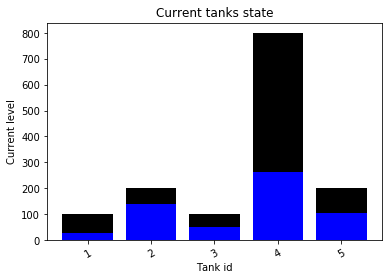

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

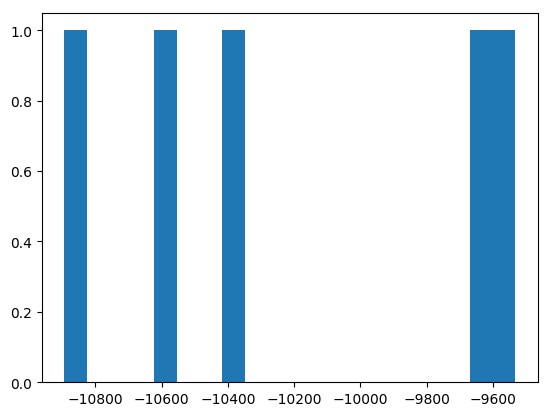

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [15]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


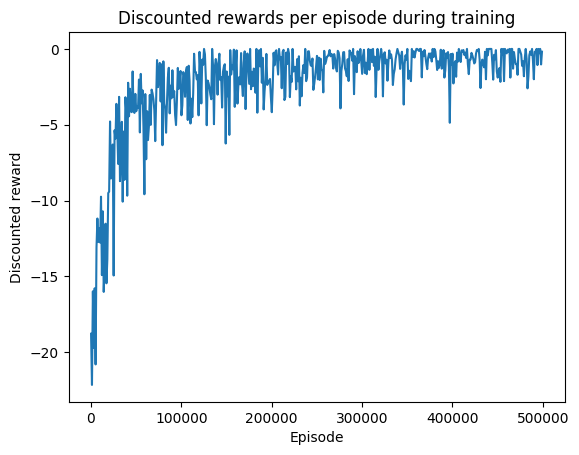

In [16]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [23]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [27]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )


    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -540.6503856 22.7233344 563.37372 4500
Episode 1 t 2 -871.8093489 -297.6015189 574.20783 1500
Episode 1 t 3 -552.5872552 -437.0234152 115.56384 0500
Episode 1 t 4 -1008.425877 -445.052157 563.37372 4500
Episode 1 t 5 -2009.8973289 -378.5899089 1631.30742 2300
Episode 1 t 6 -1759.2454149 -149.6062149 1609.6392 4300
Episode 1 t 7 -1281.3010145 -717.9272945 563.37372 4500
Episode 1 t 8 -87.4827767 28.0810633 115.56384 0500
Episode 1 t 9 -538.6433765 24.7303435 563.37372 4500
Episode 1 t 10 -1629.4472291 -19.8080291 1609.6392 3300
Episode 1 t 11 -2454.3849303 -823.0775103 1631.30742 2300
Episode 1 t 12 -1119.622404 42.206916 1161.82932 0400
Episode 1 t 13 -1574.6600135 34.9791865 1609.6392 3300
Episode 1 t 14 -538.8918807 24.4818393 563.37372 3500
Episode 1 t 15 -2052.6305557 -442.9913557 1609.6392 4300
Episode 1 t 16 -87.5665515 27.9972885 115.56384 0500
Episode 1 t 17 -1956.7784399 -325.4710199 1631.30742 23

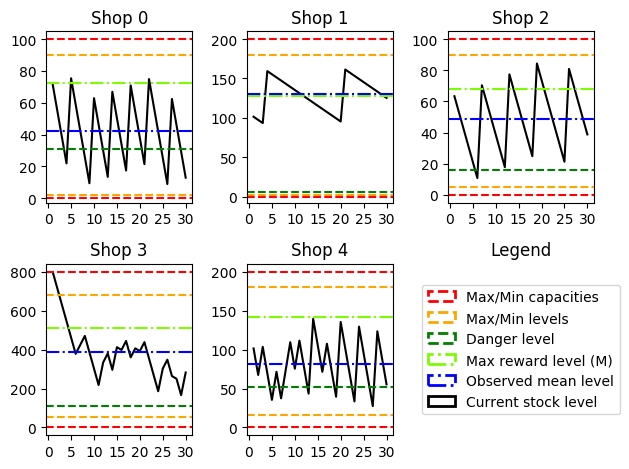

Total discounted rewards Level rewards Transport rewards
-10894.08252827437 -8887.784557953642 28361.636339999986
Average trucks sent:  42.0
Average 1st type Trucks sent to each shop: [7. 2. 4. 7. 6. 4.]
Average 1st type Trucks sent: 26.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 12.  4. 14.]
Average 2nd type Trucks sent: 16.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  1. 29.  0.]
Average level counts for shop 3: [ 0.  0.  0. 28.  2.]
Average level counts for shop 4: [ 0.  0.  6. 24.  0.]
Average total level counts: [  0.   0.  18. 130.   2.]
Percentage total level counts: [ 0.          0.         12.         86.66666667  1.33333333]


In [28]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Test episode: 12
Test episode: 13
Some tank is in a forbidden level
Test episode: 14
Test episode: 15
Test episode: 16
Test episode: 17
Test episode: 18
Some tank is in a forbidden level
Test episode: 19
Test episode: 20
Test episode: 21
Test episode: 22
Test episode: 23
Test episode: 24
Test episode: 25
Test episode: 26
Some tank is in a forbidden level
Test episode: 27
Test episode: 28
Test episode: 29
Test episode: 30
Test episode: 31
Test episode: 32
Test episode: 33
Test episode: 34
Test episode: 35
Test episode: 36
Test episode: 37
Some tank is in a forbidden level
Test episode: 38
Some tank is in a forbidden level
Test episode: 39
Test episode: 40
Test episode: 41
Test episode: 42
Test episode: 43
Test episode: 44
Test episode: 45
Test episode: 46
Some tank is in a forbidden level
Test episode: 47
Some t

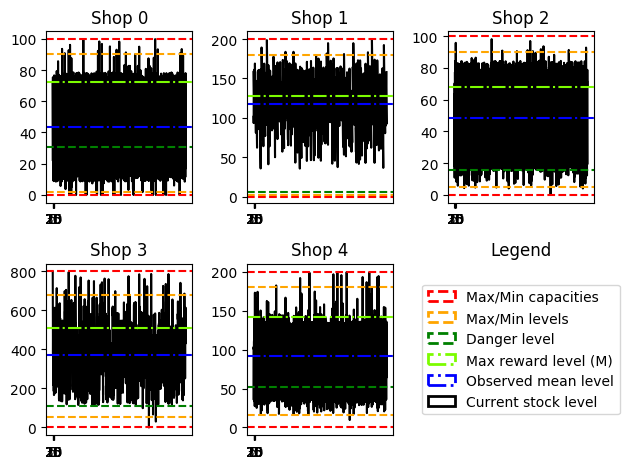

Total discounted rewards Level rewards Transport rewards
-77146.55565898021 -196451.4821352194 30938.3230395
Average trucks sent:  44.14
Average 1st type Trucks sent to each shop: [6.74 1.25 4.39 4.91 8.26 4.45]
Average 1st type Trucks sent: 25.549999999999997
Average 2nd type Trucks sent to each shop: [ 0.    0.18  0.   15.33  3.08 11.41]
Average 2nd type Trucks sent: 18.59
Average number of trucks not deliverying: 0.02
Average level counts for shop 0: [ 0.17  0.05  9.3  20.29  0.19]
Average level counts for shop 1: [ 0.   0.   0.  29.7  0.3]
Average level counts for shop 2: [1.000e-02 5.000e-02 1.070e+00 2.876e+01 1.100e-01]
Average level counts for shop 3: [1.000e-02 2.000e-02 5.000e-02 2.958e+01 3.400e-01]
Average level counts for shop 4: [0.000e+00 1.000e-02 3.740e+00 2.613e+01 1.200e-01]
Average total level counts: [1.9000e-01 1.3000e-01 1.4160e+01 1.3446e+02 1.0600e+00]
Percentage total level counts: [1.26666667e-01 8.66666667e-02 9.44000000e+00 8.96400000e+01
 7.06666667e-01]


In [25]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)